In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
import h5py
from pylab import *
%matplotlib inline
FTRAIN = 'training.csv'
FTEST = 'test.csv'

In [2]:
def writeHdf5(t,data,label=None):
	with h5py.File(os.getcwd()+ '/h5/'+t + '_data.h5', 'w') as f:
		f['data'] = data
		if label is not None:
			f['label'] = label
	with open(os.getcwd()+ '/h5/'+t + '_data_list.txt', 'w') as f:
		f.write(os.getcwd()+ '/h5/' +t + '_data.h5\n')

In [3]:
def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        #X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y

In [4]:
X, y = load()
X = X.reshape((X.shape[0],1,96,96))
#sep = 1600
#writeHdf5('train',X[0:sep],y[0:sep])
#writeHdf5('val',X[sep:],y[sep:])

#X,y= load()
#X = X.reshape((X.shape[0],1,96,96))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

(2140, 1, 96, 96) (2140, 30)
(96, 96)
[ 0.37569925 -0.18745263 -0.37027067 -0.24121504  0.24129324 -0.17401204
  0.5235489  -0.16729173 -0.24257143 -0.22105414 -0.51139849 -0.22105414
  0.18652631 -0.39513233  0.67139852 -0.32858044 -0.16192481 -0.39578497
 -0.65924209 -0.38234437 -0.07457143  0.18889172  0.27490225  0.66604513
 -0.40386465  0.61227065 -0.09765413  0.51948869 -0.10144361  0.76012027]


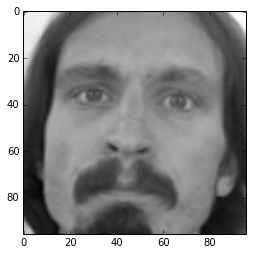

In [9]:
print X.shape, y.shape
print X[0,:,:,:].squeeze().shape
imshow(X[0,:,:,:].squeeze(), cmap='gray')
print y[0]

In [10]:
def plot_training(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=15)



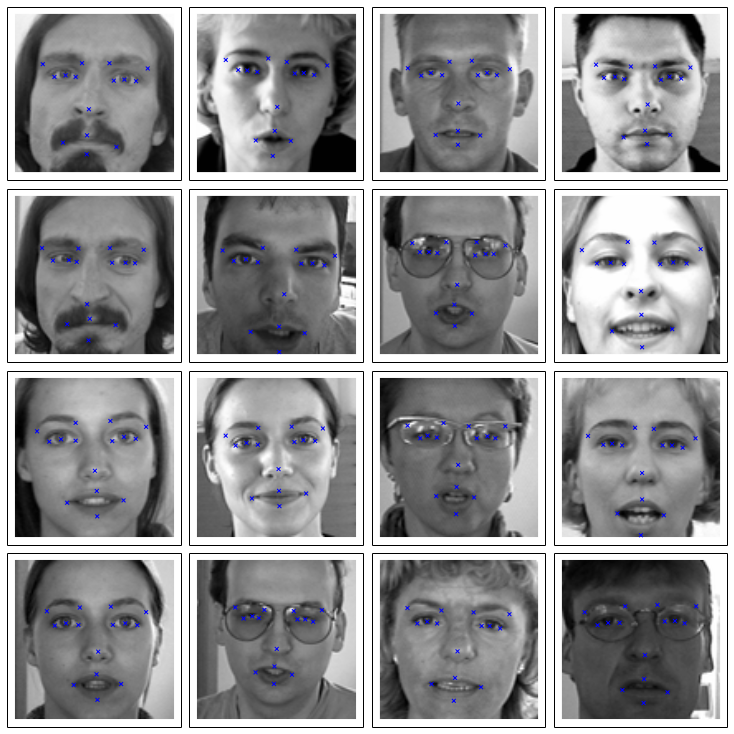

In [12]:
fig = figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_training(X[i,:,:,:].squeeze(), y[i], ax)

show()

In [13]:
sep = 1600
writeHdf5('train',X[0:sep],y[0:sep])
writeHdf5('val',X[sep:],y[sep:])



In [14]:
X,y= load(True)
X = X.reshape((X.shape[0],1,96,96))
writeHdf5('test',X,y)

ImageId    1783
Image      1783
dtype: int64


In [ ]:
#./build/tools/caffe train -solver examples/kaggle_facialpoints/fkp_solver.prototxt -gpu 0

In [16]:
!cat fkp_solver.prototxt

# The training protocol buffer definition
net: "examples/kaggle_facialpoints/fkp_net.prototxt"
# The testing protocol buffer definition
# test_iter specifies how many forward passes the test should carry out.
# In the case of facialpoint, we have test batch size 80 and 43 test iterations,
# covering the full 10,000 testing images.
test_iter: 1
# Carry out testing every 500 training iterations.
test_interval: 500
# The base learning rate, momentum and the weight decay of the network.
base_lr: 0.003
weight_decay : 0.0005
solver_type : NESTEROV
momentum: 0.9
# The learning rate policy
lr_policy: "fixed"
gamma: 0.0001
power: 0.75
stepsize: 100000
# Display every 100 iterations
display: 100
# The maximum number of iterations
max_iter: 1000000
# snapshot intermediate results
snapshot: 5000
snapshot_prefix: "examples/kaggle_facialpoints/model/fkp"
# solver mode: CPU or GPU
solver_mode: GPU


In [17]:
!cat fkp_net.prototxt

name: "fkp_net"
layer {
  name: "MyData"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/kaggle_facialpoints/h5/train_data_list.txt"
    batch_size: 128
    shuffle: true
  }
  include: { phase: TRAIN }
}
layer {
  name: "MyData"
  type: "HDF5Data"
  top: "data"
  top: "label"
  hdf5_data_param {
    source: "examples/kaggle_facialpoints/h5/val_data_list.txt"
    batch_size: 540
  }
  include: { phase: TEST }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  convolution_param {
    num_output: 20
    kernel_size: 5
    stride: 1
    weight_filler {
      type: "xavier"
      variance_norm: AVERAGE
    }
    bias_filler {
      type: "constant"
      value: 0
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}

layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    ker

In [22]:

print '=============Data Layer has images and label ============'
print 'Top shape: 128 1 96 96 (1179648)'
print 'I0505 12:00:14.063249 13857 net.cpp:151] Top shape: 128 30 (3840)'
print '=========== This is the output prediction before Euclidean Loss == Please see that the size is same as label'
print 'I0505 12:00:14.186517 13857 net.cpp:151] Top shape: 128 30 (3840)'
print '===This is the EuclideanLoss\
layer {\n\
  name: "loss"\n\
  type: "EuclideanLoss"\n\
  bottom: "fc6"\n\
  bottom: "label"\n\
  top: "loss"\n\
}'

=============Data Layer has images and label ============
Top shape: 128 1 96 96 (1179648)
I0505 12:00:14.063249 13857 net.cpp:151] Top shape: 128 30 (3840)
=========== This is the output prediction before Euclidean Loss == Please see that the size is same as label
I0505 12:00:14.186517 13857 net.cpp:151] Top shape: 128 30 (3840)
===This is the EuclideanLosslayer {
  name: "loss"
  type: "EuclideanLoss"
  bottom: "fc6"
  bottom: "label"
  top: "loss"
}


In [23]:
def predictImg(data4D,layername):
    data4DL = np.zeros([data4D.shape[0],1,1,1])   
    net.set_input_arrays(data4D.astype(np.float32),data4DL.astype(np.float32))
    out = net.forward()
    prediction = net.blobs[layername].data
    return prediction
  
def plot_sample(x, y, axis):
    img = x.reshape(height, height)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * height/2 + height/2, y[1::2] * height/2 + height/2, marker='x', s=10)

(1783, 1, 96, 96)


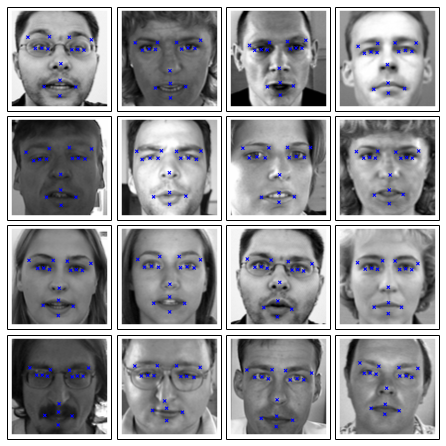

In [29]:
import caffe
MODEL_FILE = 'fkp_deploy.prototxt'
PRETRAINED = 'model/fkp_iter_1000000.caffemodel' 
height = 96
t = 'h5/test'
f = h5py.File(t + '_data.h5','r')
X = f['data'][:]
print X.shape
net=caffe.Net(MODEL_FILE,PRETRAINED,caffe.TEST)
y_pred = predictImg(X,'fc6')

fig = figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)
show()